In this notebook I use a simplified version of the VGG-16 model as described here: (https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/). I use the cleaner dataset. 

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

## Generate a keras Dataset

In [2]:
data_fld = '/home/ahoag/ML/mars/attempt2/images_for_cnn'

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)

Found 1500 files belonging to 2 classes.
Using 1200 files for training.
Found 1500 files belonging to 2 classes.
Using 300 files for validation.


## Visualize the data

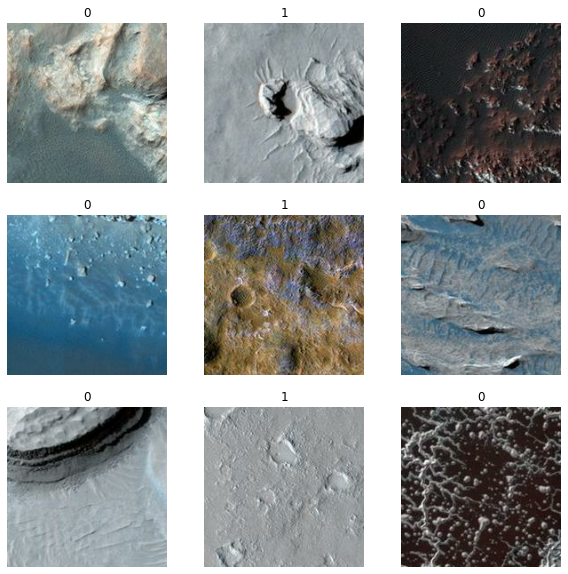

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Take grabs items at the batch level
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

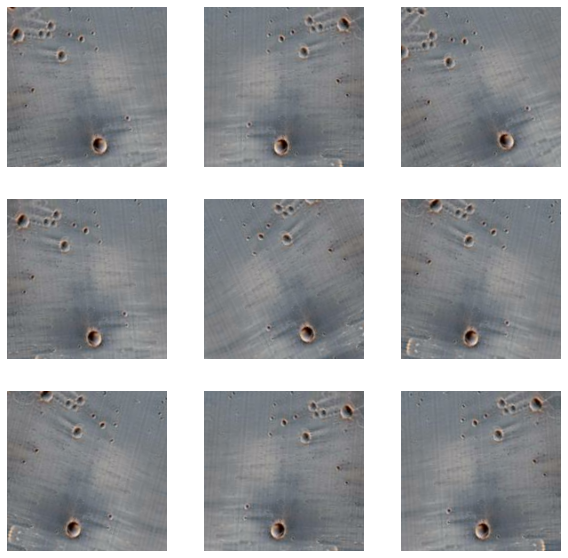

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configure the dataset for performance

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

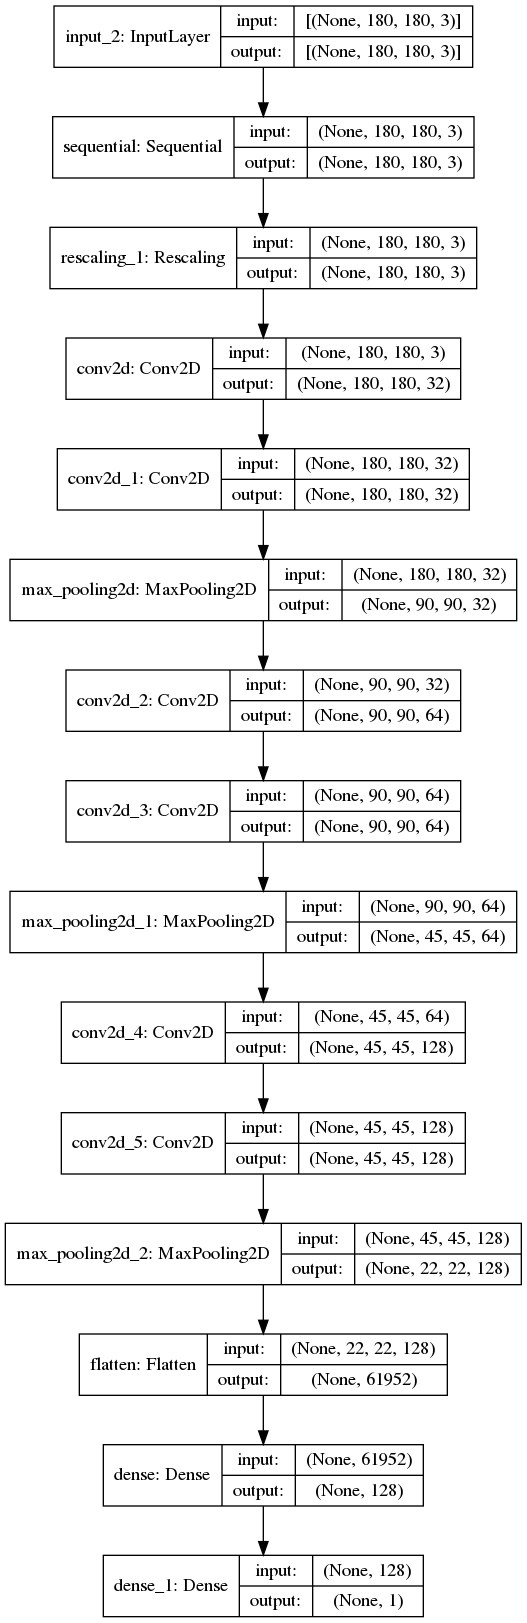

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    # rescaling 
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
   
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496 

## Train the model

In [11]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("/home/ahoag/ML/mars/vgg/cnn_saved_epochs/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
38/38 [==============================] - 47s 1s/step - loss: 5.0678 - accuracy: 0.4641 - val_loss: 0.6959 - val_accuracy: 0.4533
Epoch 2/50
38/38 [==============================] - 46s 1s/step - loss: 0.6931 - accuracy: 0.5093 - val_loss: 0.6949 - val_accuracy: 0.4533
Epoch 3/50
38/38 [==============================] - 46s 1s/step - loss: 0.6930 - accuracy: 0.5037 - val_loss: 0.6935 - val_accuracy: 0.4567
Epoch 4/50
38/38 [==============================] - 47s 1s/step - loss: 0.6939 - accuracy: 0.5050 - val_loss: 0.6938 - val_accuracy: 0.4533
Epoch 5/50
38/38 [==============================] - 47s 1s/step - loss: 0.6933 - accuracy: 0.4911 - val_loss: 0.6943 - val_accuracy: 0.4533
Epoch 6/50
38/38 [==============================] - 47s 1s/step - loss: 0.6933 - accuracy: 0.5012 - val_loss: 0.6952 - val_accuracy: 0.4533
Epoch 7/50
38/38 [==============================] - 46s 1s/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6986 - val_accuracy: 0.4533
Epoch 8/50
38/38 [==

KeyboardInterrupt: 

I stopped the training prematurely because the model was not learning at all. 